In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [20]:
train_audio_path = '/Users/suryakanoria/Projects/Data_Science_Team_Project/CNN/speech_commands_v0.01'
filename = '/yes/b00c4c53_nohash_1.wav'
samples, sample_rate = librosa.load(str(train_audio_path)+filename)

In [7]:
class EDA:
    def __init__(self,directory_path):
        self.directory_path = directory_path
    
    def plot_histogram(self):
        dirs = [f for f in os.listdir(self.directory_path) if isdir(join(self.directory_path, f))]
        dirs.sort()
        number_of_recordings = []
        for direct in dirs:
            waves = [f for f in os.listdir(join(self.directory_path, direct)) if f.endswith('.wav')]
            number_of_recordings.append(len(waves))
        # Plot
        data = [go.Histogram(x=dirs, y=number_of_recordings)]
        trace = go.Bar(
            x=dirs,
            y=number_of_recordings,
            marker=dict(color = number_of_recordings, showscale=True
            ),
        )
        layout = go.Layout(
            title='Number of recordings in given label',
            xaxis = dict(title='Words'),
            yaxis = dict(title='Number of recordings')
        )
        py.iplot(go.Figure(data=[trace], layout=layout))


In [37]:
class FileProcessor:
    def __init__(self,directory_name,file_name):
        self.file_path = str(directory_name)+filename
        self.samples, self.sample_rate = librosa.load(str(directory_name)+filename)
        
    def log_specgram(self, window_size=20,
                 step_size=10, eps=1e-10):
        nperseg = int(round(window_size * self.sample_rate / 1e3))
        noverlap = int(round(step_size * self.sample_rate / 1e3))
        self.freqs, self.times, spec = signal.spectrogram(self.samples,
                                    fs=self.sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
        self.spec = np.log(spec.T.astype(np.float32) + eps)

    def plot_specgram(self):
        fig = plt.figure(figsize=(14, 8))
        ax1 = fig.add_subplot(211)
        ax1.set_title('Raw wave of ' + filename)
        ax1.set_ylabel('Amplitude')

        ax1.plot(np.linspace(0, self.sample_rate/len(self.samples), self.sample_rate), self.samples)

        ax2 = fig.add_subplot(212)
        ax2.imshow(self.spec.T, aspect='auto', origin='lower', 
        extent=[self.times.min(), self.times.max(), self.freqs.min(), self.freqs.max()])
        ax2.set_yticks(self.freqs[::16])
        ax2.set_xticks(self.times[::16])
        ax2.set_title('Spectrogram of ' + self.file_path)
        ax2.set_ylabel('Freqs in Hz')
        ax2.set_xlabel('Seconds')
        
    def get_mel_spectogram(self):
        S = librosa.feature.melspectrogram(self.samples, sr=self.sample_rate, n_mels=128)

        # Convert to log scale (dB). We'll use the peak power (max) as reference.
        self.log_S = librosa.power_to_db(S, ref=np.max)
    
    def plot_mel_spectogram(self):
        plt.figure(figsize=(12, 4))
        librosa.display.specshow(self.log_S, sr=self.sample_rate, x_axis='time', y_axis='mel')
        plt.title('Mel power spectrogram ')
        plt.colorbar(format='%+02.0f dB')
        plt.tight_layout()
    
    def get_delta(self):
        mfcc = librosa.feature.mfcc(S=self.log_S, n_mfcc=13)

        # Let's pad on the first and second deltas while we're at it
        self.delta2_mfcc = librosa.feature.delta(mfcc, order=2)

    def plot_delta(self):
        plt.figure(figsize=(12, 4))
        librosa.display.specshow(self.delta2_mfcc)
        plt.ylabel('MFCC coeffs')
        plt.xlabel('Time')
        plt.title('MFCC')
        plt.colorbar()
        plt.tight_layout()

In [30]:
train_audio_path = '/Users/suryakanoria/Projects/Data_Science_Team_Project/CNN/speech_commands_v0.01'
filename = '/yes/0a7c2a8d_nohash_0.wav'
eda = EDA(train_audio_path)
eda.plot_histogram()

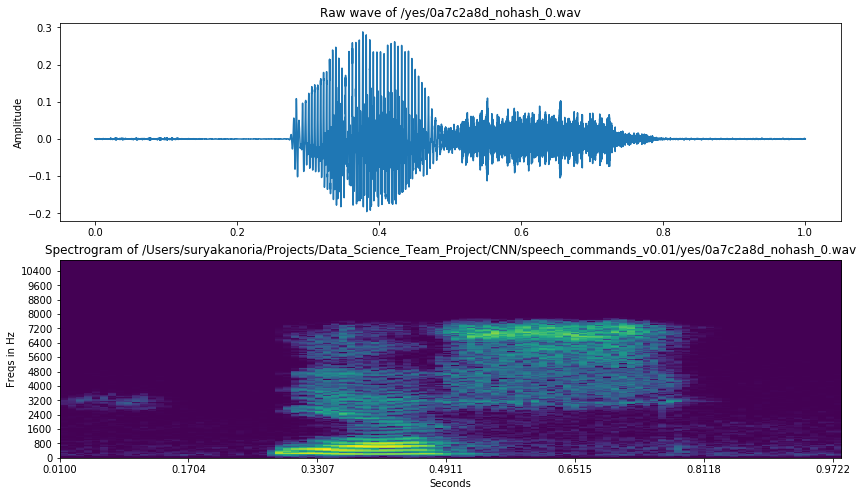

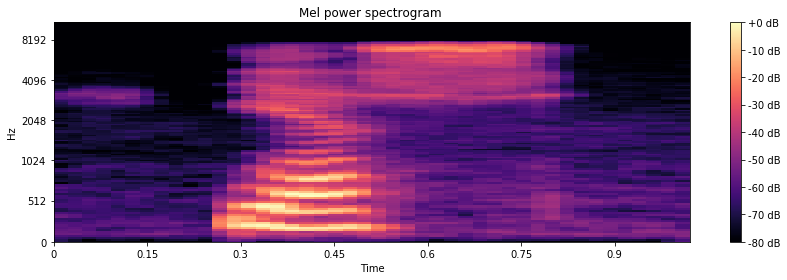

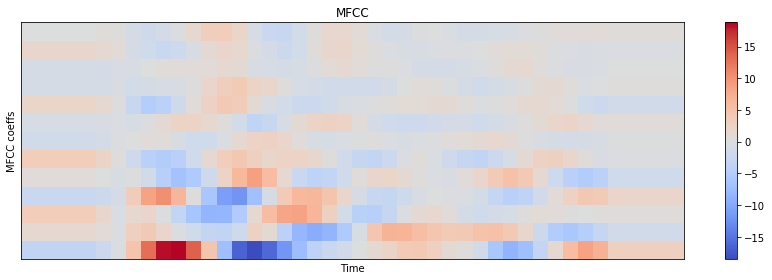

In [38]:
file_processor = FileProcessor(train_audio_path,filename)
file_processor.log_specgram()
file_processor.plot_specgram()
file_processor.get_mel_spectogram()
file_processor.plot_mel_spectogram()
file_processor.get_delta()
file_processor.plot_delta()

In [39]:
from keras.engine import Layer, InputSpec
from keras.layers import Flatten
import tensorflow as tf

class KMaxPooling(Layer):
    """
    K-max pooling layer that extracts the k-highest activations from a sequence (2nd dimension).
    TensorFlow backend.
    """
    def __init__(self, k=1, **kwargs):
        super().__init__(**kwargs)
        self.input_spec = InputSpec(ndim=3)
        self.k = k

    def compute_output_shape(self, input_shape):
        return (input_shape[0], (input_shape[2] * self.k))

    def call(self, inputs):
        
        # swap last two dimensions since top_k will be applied along the last dimension
        shifted_input = tf.transpose(inputs, [0, 2, 1])
        
        # extract top_k, returns two tensors [values, indices]
        top_k = tf.nn.top_k(shifted_input, k=self.k, sorted=True, name=None)[0]
        
        # return flattened output
        return Flatten()(top_k)

ModuleNotFoundError: No module named 'keras'